In [1]:
from __future__ import print_function

In [2]:
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import imgaug as ia
from imgaug import augmenters as iaa

%pylab inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


In [3]:
trg = pd.read_csv("trg.csv")
trg.head()

,N,Xo,Yo,X1,W
0,0,0.506,0.773,0.536,0.030
1,1,0.502,0.790,0.500,0.034
2,2,0.544,0.662,0.590,0.048
3,3,0.494,0.761,0.520,0.060
4,4,0.512,0.896,0.520,0.020


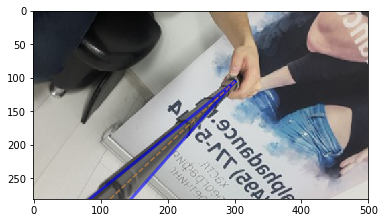

In [23]:
n = 106
img = Image.open("crops/"+"img_"+str(n+1)+".jpg")
imw, imh = img.size
img_arr = np.array(img, dtype=np.float32)/255

X1 = int(trg.iloc[n].X1*imw)
X2 = int(trg.iloc[n].Xo*imw)
Y1 = imh
Y2 = int(trg.iloc[n].Yo*imh)
W = int(trg.iloc[n].W*imw)
kmax_crop = 0.3
maxmax_crops = (int(imw*kmax_crop), int(imh*kmax_crop))
max_crops = (min(max(min(X1, X2)-int(W/2), 0), maxmax_crops[1]), 
             min(max(imw-max(X1, X2)-int(W/2), 0), maxmax_crops[0]),
             min(max(imh-Y2, 0), maxmax_crops[0]))

seq = iaa.Sequential([
    iaa.Crop(px=((0, max_crops[2]),
                 (0, max_crops[1]),
                 (0, 0),
                 (0, max_crops[0]))),
    iaa.Fliplr(p=0.5)
])
seq_det = seq.to_deterministic()

augmented_kp = []
kp = []

kp.append(ia.Keypoint(x=int(X1-W/2), y=Y1))
kp.append(ia.Keypoint(x=int(X1+W/2), y=Y1))
kp.append(ia.Keypoint(x=X2, y=Y2))
augmented_kp.append(ia.KeypointsOnImage(kp, shape=img_arr.shape))

img_arr = seq_det.augment_image(img_arr)
augmented_kp = seq_det.augment_keypoints(augmented_kp)[0].keypoints


x2_aug = augmented_kp[2].x
y2_aug = augmented_kp[2].y
x1_aug = int(mean([augmented_kp[1].x, augmented_kp[0].x]))
y1_aug = Y1
for shift in range(2):
    xw_aug = augmented_kp[shift].x
    plt.plot([xw_aug, x2_aug], [y1_aug, y2_aug], c='blue', linewidth=3, alpha=0.6);
    plt.plot([x1_aug, x2_aug], [y1_aug, y2_aug], "--", alpha=0.6);
plt.imshow(img_arr);

In [380]:
seq

Sequential(name=UnnamedSequential, random_order=False, children=[CropAndPad(name=UnnamedCrop, parameters=[None, DiscreteUniform(Deterministic(int 0), Deterministic(int -100)), DiscreteUniform(Deterministic(int 0), Deterministic(int -100)), DiscreteUniform(Deterministic(int 0), Deterministic(int 0)), DiscreteUniform(Deterministic(int 0), Deterministic(int -56)), Deterministic(constant), Deterministic(int 0)], deterministic=False)], deterministic=False)

In [ ]:
def getImgData(trgBase, img_type, imgHeight, imgWidth, write_file = False):
# import images into pd-dataframe
    trg = []
    imgList = []

    for i, nImg in enumerate(trgBase.N[:]):
        imgOrigin = importImg(nImg, 500, None, 'crops/')
        print(nImg, end=' ')
        for kHeight, kWidth in [(1, 1)]:#, (1, -0.85), (1, 0.85), (0.85, 1), (0.7, 1)]:
            newHeight = kHeight*imgOrigin.height 
            if kWidth>=0:
                newWidth = [0, kWidth*imgOrigin.width]
                dx = 0
            else:
                newWidth = [(1+kWidth)*imgOrigin.width, imgOrigin.width]  
                dx = 1+kWidth
                
            newXo = (trgBase.Xo.values[i]-dx)/abs(kWidth)
            newX1 = (trgBase.X1.values[i]-dx)/abs(kWidth)
            newYo = trgBase.Yo.values[i]/kHeight+1-1/kHeight
            newW = trgBase.W1.values[i]/abs(kWidth)
            if 0<newXo<1 and 0<newX1<1:
                imgCroped = imgOrigin.crop((newWidth[0], int(imgOrigin.height*(1-kHeight)), newWidth[1], imgOrigin.height))         
                        
                trg.append([newXo, newYo, newX1, newW])
                    
                imgCropedScaled  = imgCroped.resize((imgWidth, imgHeight))
                imgArray = np.power(np.array(imgCropedScaled, dtype=float)/255, 1)
                imgList.append(imgArray.flatten())
    
    trg = pd.DataFrame(data=trg, columns=['Xo', 'Yo', 'X1', 'W'])
    imgData = pd.DataFrame(data=imgList, columns=range(len(imgList[0])))
    if write_file:
        imgData.to_csv('img_data.csv', index=False)
        trg.to_csv('targets_data.csv', index=False)
    print(imgData.shape)
    
    if img_type == 'bw':
        x = imgData.values.reshape(-1, imgHeight,imgWidth, 1)
    else:
        x = imgData.values.reshape(-1, imgHeight,imgWidth, 3)
    
    #for layer in range(1):
    #    xBW = x[:, :,:,layer:layer+1].mean(axis=3)>0.5
    #    x = np.concatenate((x, np.expand_dims(xBW, 3)), axis=3)
    return x, trg

In [118]:
trg = pd.read_csv("targets/coordinates.csv", usecols=["Xo", "X1", "Yo", "W1"])

In [160]:
dir = "crops/"
trg_new = []
img_new = []
mode = 1
for i, row in enumerate(trg.index):
    c = trg.iloc[i]
    img = Image.open(dir+"img_"+str(i+1)+".jpg")
    if img.height>400:
        continue
    if mode==0:
        c_crop = c.copy()
        img_crop = img.crop((0,0,img.height,img.height))
    else:
        c_crop = c.copy()
        
        dx_lim_left = img.width-c_crop.X1-img.height/2
        dx_lim_right = c_crop.X1-img.height/2
        
        dx = 200*(0.5-np.random.random(1)[0])
        dx = -min(dx,dx_lim_right)
        dx = min(dx,dx_lim_left)
        img_crop = img.crop((c_crop.X1-img.height/2+dx,0,c_crop.X1+img.height/2+dx,img.height))
        
        c_crop.Xo += img.height/2-c_crop.X1-dx
        c_crop.X1 = img.height/2-dx
        
        
        
    if c_crop.Xo>img.height or c_crop.X1>img.height or c_crop.Xo<0 or c_crop.X1<0:
        continue
        
    trg_new.append(c_crop)
    img_new.append(img_crop)
    
    print(i, img.size, img_crop.size, c.values, c_crop.values, dx_lim_right, dx_lim_left, dx)    

0 (500, 375) (375, 375) [268 253 290  15] [205 190 290  15] 80.5 44.5 -18.1348008264971
1 (500, 333) (333, 333) [250 251 263  17] [170 171 263  17] 83.5 83.5 -4.3939212407176464
3 (500, 280) (280, 280) [260 247 213  30] [ 41  28 213  30] 120.0 100.0 98.20255127345217
4 (500, 375) (375, 375) [260 256 336  10] [210 206 336  10] 72.5 52.5 -22.930727897381487
5 (500, 375) (375, 375) [296 263 283  30] [171 138 283  30] 108.5 16.5 16.5
10 (500, 400) (400, 400) [250 240 317  13] [185 175 317  13] 50.0 50.0 14.64671374802855
11 (500, 252) (252, 252) [256 244 180  32] [ 44  32 180  32] 130.0 118.0 81.1093881537139
12 (500, 375) (375, 375) [272 242 280  24] [220 190 280  24] 84.5 40.5 -32.94083406902144
13 (500, 281) (281, 281) [238 236 227  13] [218 216 227  13] 97.5 121.5 -78.30422576343446
16 (500, 361) (361, 361) [281 238 222  28] [249 206 222  28] 100.5 38.5 -68.5537635965344
17 (500, 375) (375, 375) [287 257 275  30] [162 132 275  30] 99.5 25.5 25.5
18 (500, 400) (400, 400) [281 243 279  4

167 (500, 375) (375, 375) [281 252 240  30] [164 135 240  30] 93.5 31.5 23.055376327944586
169 (500, 332) (332, 332) [256 247 278  14] [134 125 278  14] 90.0 78.0 31.823099554830915
170 (500, 326) (326, 326) [280 258 203  32] [106  84 203  32] 117.0 57.0 57.0
171 (500, 375) (375, 375) [133 221 284  23] [133 221 284  23] -54.5 179.5 54.5
172 (500, 375) (375, 375) [129 222 281  20] [129 222 281  20] -58.5 183.5 58.5
173 (500, 375) (375, 375) [170 224 328  20] [144 198 328  20] -17.5 142.5 42.57828581750835
174 (500, 375) (375, 375) [164 292 217  40] [ 96 224 217  40] -23.5 148.5 91.43125464007336
175 (500, 375) (375, 375) [165 233 305  20] [ 99 167 305  20] -22.5 147.5 88.08877328257093
176 (500, 375) (375, 375) [133 218 283  20] [133 218 283  20] -54.5 179.5 54.5
177 (500, 375) (375, 375) [163 293 214  40] [104 234 214  40] -24.5 149.5 83.17803804181753
178 (500, 375) (375, 375) [133 219 282  20] [133 219 282  20] -54.5 179.5 54.5
179 (500, 375) (375, 375) [133 219 282  20] [133 219 282

269 (500, 281) (281, 281) [274 251 180  15] [174 151 180  15] 133.5 85.5 -33.87639423294502
270 (500, 281) (281, 281) [274 251 180  15] [198 175 180  15] 133.5 85.5 -58.20605385691178
271 (500, 281) (281, 281) [274 251 180  15] [129 106 180  15] 133.5 85.5 11.173357446895938
272 (500, 281) (281, 281) [274 251 180  15] [ 58  35 180  15] 133.5 85.5 81.52363801379916
273 (500, 281) (281, 281) [274 251 180  15] [170 147 180  15] 133.5 85.5 -30.444894839189686
274 (500, 281) (281, 281) [274 251 180  15] [225 202 180  15] 133.5 85.5 -84.77234390078925
275 (500, 281) (281, 281) [274 251 180  15] [109  86 180  15] 133.5 85.5 30.76257367224624
276 (500, 281) (281, 281) [274 251 180  15] [168 145 180  15] 133.5 85.5 -28.12225604005334
277 (500, 281) (281, 281) [274 251 180  15] [160 137 180  15] 133.5 85.5 -19.592150970546452
278 (500, 281) (281, 281) [270 265 237  25] [228 223 237  25] 129.5 89.5 -88.03714702297178
279 (500, 281) (281, 281) [270 265 237  25] [ 87  82 237  25] 129.5 89.5 53.1334

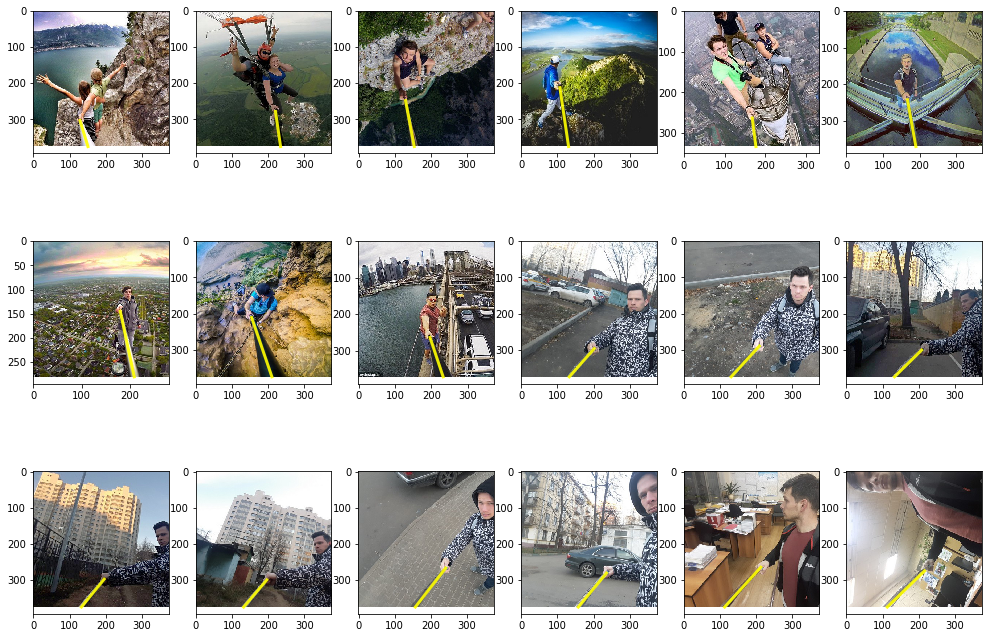

In [162]:
plt.subplots(figsize=(17,12))
nStart = 60
for nImg in range(nStart, nStart+18):
    plt.subplot(3,6,nImg-nStart+1)
    pylab.imshow(img_new[nImg]);
    X1 = trg_new[nImg].X1
    X2 = trg_new[nImg].Xo
    Y2 = trg_new[nImg].Yo
    W1 = trg_new[nImg].W1
    plt.plot([X1, X2],
                 [img_new[nImg].height, Y2], 
                 c='yellow', 
                 linewidth=3,
                 alpha=0.9);